# CSI 4142 Deliverable 2 - Phase 2
### Group 35
- Yasin Elmi, 300163765
- Oluwatobiloba Ogunbi, 300202843
- Michael Thompson, 300175414

## Intial reading of files into dataframes (Extraction)

The following data was extracted from Kaggle (refer to the submitted delivereable document for it's reference)
Note: may need to adjust the file name and/or location if this notebook is not within the same directory as the data files.

In [4]:
import pandas as pd
import json

df_movies = pd.read_csv('datasets/tmdb_5000_movies.csv', index_col=False)
df_credits = pd.read_csv('datasets/tmdb_5000_credits.csv')
df_continents = pd.read_csv('datasets/countries_by_continent.csv') # Added dataset for creating rollup/drilldown on countries
print(df_continents)

         Continent    Country
0           Africa    Algeria
1           Africa     Angola
2           Africa      Benin
3           Africa   Botswana
4           Africa    Burkina
..             ...        ...
196  South America   Paraguay
197  South America       Peru
198  South America   Suriname
199  South America    Uruguay
200  South America  Venezuela

[201 rows x 2 columns]


## 1. - Working on tmdb_5000_movies.csv
Below is the transformation steps on the movies table

### 1.1. - Dropping & converting columns of movies data
Initial dropping of unnecessary columns, according to our first deliverable plan

In [5]:
# Dropping unneccessary columns
df_movies = df_movies.drop('homepage', axis=1)
#df_movies = df_movies.drop('id', axis=1)
df_movies = df_movies.drop('keywords', axis=1)
df_movies = df_movies.drop('overview', axis=1)
df_movies = df_movies.drop('status', axis=1)
df_movies = df_movies.drop('tagline', axis=1)

### 1.2. - Dropping rows of movies data
We will begin by initially dropping rows where both the 'budget' and 'revenue' value are 0 (previously determined that there exists no null values in these columns). Both of these values are pertinent to our investigation, and it would be inappropriate to assign an estimated or calculated value for both of these columns. Thus, in the case of our investigatin, we will drop these rows (890 rows).

In [6]:
# Dropping all rows where both the budget and revenue column are 0
# These values being 0 present no value to our investigation, and would be filled with 
print(len(df_movies))
index_revenue_budget = df_movies[ (df_movies['revenue']==0) & (df_movies['budget']==0) ].index
df_movies = df_movies.drop(index_revenue_budget)
print(len(df_movies))


4803
3913


### 1.3. - Checking for null in movies data
Below we check for rows that are null. In our case, there are only two null values that are present found in the 'runtime' column. Since it isn't appropriate to assume or calculate a potential runtime based on other movies, we will assign all movies with runtime 'Nan' or '0' as -1. Thus, during our investigations we are aware of the incomplete data present for consideration.

In [7]:
# Check for other Null or NaN values
df_movies[df_movies.isnull().any(axis=1)]

,budget,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count
2656,15000000,"[{""id"": 18, ""name"": ""Drama""}]",370980,it,Chiamatemi Francesco - Il Papa della gente,0.738646,"[{""name"": ""Taodue Film"", ""id"": 45724}]","[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",2015-12-03,0,NaN,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Chiamatemi Francesco - Il Papa della gente,7.3,12
4140,2,"[{""id"": 99, ""name"": ""Documentary""}]",459488,en,"To Be Frank, Sinatra at 100",0.050625,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2015-12-12,0,NaN,[],"To Be Frank, Sinatra at 100",0.0,0


### 1.4. - Checking for 'Noisy' values in movies data
Below is an investigation on 'noisy' values, which appear to be empty cells assigned some place holder value. They are as follows
- 147 rows with df_movies['budget'] = 0
- 4 rows with df_movies['genres'] = '[]' (placeholder for an empty cell)
- 0 rows with df_movies['original_language'] = ''
- 0 rows with df_movies['original_title'] = ''
- 0 rows with df_movies['popularity'] = 0
- 100 rows with df_movies['production_companies'] = '[]' (placeholder for an empty cell)
- 47 rows with df_movies['production_countries'] = '[]' (placeholder for an empty cell)
- 537 rows with df_movies['revenue'] = 0
- 0 rows with df_movies['title'] = ''
- 3 rows with df_movies['runtime'] = 0 + 2 rows with df_movies['runtime'] = NaN (as detailed above)
- 166 rows where the df_movies['original_title'] != df_movies['title']. This can be assumed that foreign films have an original title name different than it's English title. This is useful to know, as when staging we will utilize the 'title' column and not the 'original_title'.
- 11 rows with df_movies['vote_average'] = 0
- 11 rows with df_movies['vote_count'] = 0 

In [8]:
# 1037 rows with 'budget' = 0
    # We can use median
# 28 rows with 'genre' = ''
    # Use special value 'Unknown'
# 351 rows with 'production_companies' = ''
    # Use special value 'Independent'
# 174 rows with 'production_countries' = ''
    # Use special value 'Unknown'
# 35 rows with 'runtime' = 0 AND 2 rows with 'runtime' = NaN
    # Use special value -1
# 1427 rows with revenue = 0
    # Check median and mean value of 'revenue' column, select which one appears to be more appropriate 
# 1 row with popularity = 0 (I think this is safe - unpopular movie?)
    # keep this value
# 63 rows with vote_average = 0.0
    # Leave this value 0, as it is possible these movies have received no votes and thus no average can be made (avg of 0 is 0)
# 62 rows with vote_count = 0
    # Leave this value 0, as it is possible these movies have received no votes on the site


# 261 rows where original title != title (Thinking foreign films?)


print("# Rows where budget=0: " + str(len(df_movies.loc[df_movies['budget']==0])))
print("# Rows where genres='[]': " + str(len(df_movies.loc[df_movies['genres']=='[]'])))
print("# Rows where original_language='': " + str(len(df_movies.loc[df_movies['original_language']==''])))
print("# Rows where original_title='': " + str(len(df_movies.loc[df_movies['original_title']==''])))
print("# Rows where popularity=0.0: " + str(len(df_movies.loc[df_movies['popularity']==0.0])))
print("# Rows where production_companies='[]': " + str(len(df_movies.loc[df_movies['production_companies']=='[]'])))
print("# Rows where production_countries='[]': " + str(len(df_movies.loc[df_movies['production_countries']=='[]'])))
print("# Rows where revenue=0: " + str(len(df_movies.loc[df_movies['revenue']==0])))
print("# Rows where title='': " + str(len(df_movies.loc[df_movies['title']==''])))
print("# Rows where runtime=0: " + str(len(df_movies.loc[df_movies['runtime']==0])))
print("# Rows where spoken_languages='[]': " + str(len(df_movies.loc[df_movies['spoken_languages']=='[]'])))
print("# Rows where title != original_title: " + str(len(df_movies.loc[df_movies['title'] !=df_movies['original_title']])))
print("# Rows where vote_average=0.0: " + str(len(df_movies.loc[df_movies['vote_average']==0.0])))
print("# Rows where vote_count=0: " + str(len(df_movies.loc[df_movies['vote_count']==0])))



# Rows where budget=0: 147
# Rows where genres='[]': 4
# Rows where original_language='': 0
# Rows where original_title='': 0
# Rows where popularity=0.0: 0
# Rows where production_companies='[]': 100
# Rows where production_countries='[]': 47
# Rows where revenue=0: 537
# Rows where title='': 0
# Rows where runtime=0: 3
# Rows where spoken_languages='[]': 26
# Rows where title != original_title: 166
# Rows where vote_average=0.0: 11
# Rows where vote_count=0: 11


### 1.5. - Handling the 'Noisy' data in movies data
Below we will be dealing with the noisy data that was identified above.
- For df_movies['budget'], we will use the **median value** of the column
- For df_movies['genres'], we will apply a **special value 'No listed genres'**
- For df_movies['production_companies'], we will apply a **special value 'Independent film'**
- For df_movies['production_countries'], we will apply a **special value 'Unknown'**
- For df_movies['revenue'], we will use the **median value** of the column
- For df_movies['runtime'], we will apply a **special value -1**
- For df_movie['vote_count'] and df_movies['vote_average'], we will refrain from performing any changes as it is possible a movie has no votes thus no vote average
- This investigation also identified that the proper title column to utilize is the df_movies['title'] column

In [9]:
# budget mean = 35651246.2358804, budget median = 20000000.0
# Based on the values above, using the median would be the most appropriate fit
# Replaces every row where budget=0 to the median
budget_median = df_movies['budget'].median()
df_movies.loc[df_movies['budget']==0, ['budget']] = budget_median 

# revenue mean = 100800794.53028367, revenue median = 35323292.0
# Based on the values above, using the median would be the most appropriate fit
# replaces every where revenue=0 to the median
revenue_median = df_movies['revenue'].median()
df_movies.loc[df_movies['revenue']==0, ['revenue']] = revenue_median

#replaces every row where runtime = 0 to -1
df_movies.loc[df_movies['runtime']==0, ['runtime']] = -1 
# replaces every row where runtime = nullValue to -1
df_movies["runtime"].fillna(-1, inplace = True)  

# Drop the 'original_title' column
df_movies.drop('original_title', axis=1)

C:\Users\yazz\AppData\Local\Temp\ipykernel_21860\2104921917.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_movies["runtime"].fillna(-1, inplace = True)


,budget,genres,id,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,en,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,en,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,en,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,en,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,en,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4791,13,"[{""id"": 27, ""name"": ""Horror""}]",157185,en,0.332679,"[{""name"": ""Park Films"", ""id"": 21871}, {""name"":...","[{""iso_3166_1"": ""IE"", ""name"": ""Ireland""}]",2007-01-01,36642838,84.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Tin Can Man,2.0,1
4792,20000,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 27, ""name...",36095,ja,0.212443,"[{""name"": ""Daiei Studios"", ""id"": 881}]","[{""iso_3166_1"": ""JP"", ""name"": ""Japan""}]",1997-11-06,99000,111.0,"[{""iso_639_1"": ""ja"", ""name"": ""\u65e5\u672c\u8a...",Cure,7.4,63
4796,7000,"[{""id"": 878, ""name"": ""Science Fiction""}, {""id""...",14337,en,23.307949,"[{""name"": ""Thinkfilm"", ""id"": 446}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2004-10-08,424760,77.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Primer,6.9,658
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",9367,es,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",El Mariachi,6.6,238


### 1.6. - Cleaning attributes containing JSON objects as String in movies data
The 'genre', 'production_companies' and 'production_countries' attributes contain a JSON as a string, which contains a desired key-value pair. A function was created to extract the desired value within the string, and return it as a list.

This is also where we will adjust for null or 'empty' values, as it is easier to process these JSON objects then clean them rather than vice versa.

In [10]:
# Cleaning the genres, production_companies and production_countries columns from json string

def extract_json_key(string, key):
    '''
    Helper function used to translate string to list of dictionaries, and extract the 'name' key-value pair
    (Str, Str) -> Str
    Preconditions: None
    '''
    clean_list = json.loads(string)
    name = [x[key] for x in clean_list]
    return ', '.join(name)

# Calling the above function to extract the respective 'name' key-value 
df_movies['genres'] = df_movies['genres'].map(lambda x: extract_json_key(x, 'name'))
df_movies['production_companies'] = df_movies['production_companies'].map(lambda x: extract_json_key(x, 'name'))
df_movies['production_countries'] = df_movies['production_countries'].map(lambda x: extract_json_key(x, 'name'))

genres_spec_val = 'No listed genres'
prod_comp_spec_val = 'Independent film'
prod_coun_spec_val = 'Unknown'
df_movies.loc[df_movies['genres']=='', ['genres']] = genres_spec_val
df_movies.loc[df_movies['production_companies'] == '', ['production_companies']] = prod_comp_spec_val
df_movies.loc[df_movies['production_countries'] == '', ['production_countries']] = prod_coun_spec_val

#### 1.7. - Cleaning the language attributes
This section is focused on cleaning the two langauge attribtues, 'original_language' and 'spoken_language'. 

'original_language' is originally written in ISO 639-1 code, which is a 2 letter abbreviation of a word. Using a dictionary found below, the word is swapped for it's verbose display.

'spoken_language' is a little more difficult, where a film can have multiple spoken languages. This is stored in a similar JSON string as above which stores both the ISO 639-1 code and the full written word. Unfortunately, the full written word may utilize a unicode character (i.e. 'French' written in French has an accent, which stores a unicode character). The solution to this is utililizing our previously made dictionary and search it using the provided ISO 639-1 code. A function takes the list of JSON objects, extracts the ISO 639-1 code and translates it, then returns.

Here is also where we fill in the null or empty cell values (denoted by '[]'). Same as above, it is easier to process the JSON objects then fill out the empty cells. Since 'original_language' has no empty values (in other words, there is a language associated with the film), we will simply use the 'original_language' to be placed within the 'spoken_language' cell.

In [11]:
# Create dictionary mapping 2 letter language abbrv. to full word
language_two_code_dict = {
    'en': 'English',
    'fr': 'French',
    'ja': 'Japanese',
    'zh': 'Chinese',
    'es': 'Spanish',
    'de': 'German',
    'hi': 'Hindi',
    'ru': 'Russian',
    'ko': 'Korean',
    'te': 'Telugu',
    'cn': 'Chinese',
    'it': 'Italian',
    'nl': 'Dutch',
    'ta': 'Tamil',
    'sv': 'Swedish',
    'th': 'Thai',
    'da': 'Danish',
    'xx': 'No Language',
    'hu': 'Hungarian',
    'cs': 'Czech',
    'pt': 'Portuguese',
    'is': 'Icelandic',
    'tr': 'Turkish',
    'nb': 'Norwegian Bokmal',
    'af': 'Afrikaans',
    'pl': 'Polish',
    'he': 'Hebrew',
    'ar': 'Arabic',
    'vi': 'Vietnamese',
    'ky': 'Kyrgyz',
    'id': 'Indonesian',
    'ro': 'Romanian',
    'fa': 'Persian',
    'no': 'Norwegian',
    'sl': 'Slovenian',
    'ps': 'Pashto',
    'el': 'Greek'
}

def language_lookup(word):
    '''
    Helper function that searches a ISO 639-1 code in the dictionary and returns the verbose word
    String -> String
    '''
    if(word in language_two_code_dict):
        return language_two_code_dict.get(word)
    else:
        return 'NEED TO DOUBLE CHECK MISSING'

df_movies['original_language'] = df_movies['original_language'].map(lambda x: language_lookup(x))


def translate_and_clean(string):
    '''
    Helper function that takes string of 2 code abbreviations, translates and returns in a String
    (Str) -> Str
    '''
    extract = extract_json_key(string, 'iso_639_1').split(',')
    for i in range(len(extract)):
        extract[i] = extract[i].strip()
        extract[i] = language_lookup(extract[i])
    
    return ', '.join(extract)

# Apply function on each row within 'spoken_languages' column
df_movies['spoken_languages'] = df_movies['spoken_languages'].map(lambda x: translate_and_clean(x))

# Fill in empty cells with the 'original_language' value of that row
print(len(df_movies['spoken_languages']))

3913


## 2. - Cleaning the tmdb_5000_credits.csv
Similar to above, below is cleaning the data found in the 'tmdb_5000_credits.csv' file.

In [12]:
def extract_json_key(string, key,i):
    '''
    Helper function used to translate string to list of dictionaries, and extract the values
    (Str, Str, int) -> Str
    Preconditions: None
    '''
    clean_list = json.loads(string)
    # print(clean_list)
    #print("index",i)
    #print("length",len(clean_list))
    return clean_list[i][key]


### 2.1 - Extraction of JSON data from credits file
Similar to the logic above (refer to 1.6.), the cast and crew data are stored in JSON objects which need to be extracted. Below we create a function (loadCast) and utilize the extract_json_key function to break up these JSON objects and store them in their respective dataframes for staging.

In [13]:
# take the movie id then parse the cast 
# MOVIE ID / NAME / GENDER / ROLE(ACTOR) 

# take the movie id then parse the cast 
# MOVIE ID / NAME / GENDER / ROLE -> job

def loadCast(cast,members):
	'''
    Function used to load data from csv file into dataframes 2 dataframes for crew members and cast members
    (dataFrame) -> dataFrame
    Preconditions: None
    '''
	for i in range (len(df_credits)):
		
		for k in range(5):
			
			if(type(df_credits[members][i])==float):
				break
			if(len(json.loads(df_credits[members][i]))<=k):
				break
			else:
				#create new table row
				new_row = {"movie_id":0,"name":"","gender":"","role":"Actor"}

				new_row["movie_id"] = df_credits["movie_id"][i]
				
				new_row["name"] = extract_json_key(df_credits[members][i], 'name',k)
				
				gender = extract_json_key(df_credits[members][i], 'gender',k)
				
				if( gender == 0 or gender == 1):

					new_row["gender"] = "male"
				else:
					new_row["gender"] = "female"
				if( members == "crew" ):
					new_row["role"] = extract_json_key(df_credits[members][i], 'job',k)

				# add table row to end of dataframe
				cast.loc[len(cast)] = new_row
	return cast
	

Here we call the above function, creating two new dataframes which break up the 'tmdb_5000_credits.csv' file into two dataframes, actors and crew.

In [14]:
actors = pd.DataFrame(columns=['movie_id', 'name', 'gender', 'role'])
crew = pd.DataFrame(columns=['movie_id', 'name', 'gender', 'role'])

actors_extracted = loadCast(actors,"cast")
crew_extracted = loadCast(crew,"crew")

print(actors_extracted)

       movie_id                name  gender   role
0         19995     Sam Worthington  female  Actor
1         19995         Zoe Saldana    male  Actor
2         19995    Sigourney Weaver    male  Actor
3         19995        Stephen Lang  female  Actor
4         19995  Michelle Rodriguez    male  Actor
...         ...                 ...     ...    ...
23589     25975      Drew Barrymore    male  Actor
23590     25975    Brian Herzlinger  female  Actor
23591     25975       Corey Feldman  female  Actor
23592     25975        Eric Roberts  female  Actor
23593     25975       Griffin Dunne    male  Actor

[23594 rows x 4 columns]


# 3. - Staging the data
Below is the staging part of our script. When staging our data, we perform a handful of steps that prepares our freshly cleaned and transformed data into dataframes. These staged dataframes are then loaded into our MySQL database.

## 3.1. - Generating Surrogate Key for each movie
Creating a surrogate key for each movie. Present in the movie dataframe is the 'id' attribute, which is a natural key. However, we will implement a surrogate key for reference with ease.

In [15]:
df_movies.insert(0, 'Surrogate Key', range(1, len(df_movies)+1))

print(df_movies)
                 

      Surrogate Key     budget                                       genres  \
0                 1  237000000  Action, Adventure, Fantasy, Science Fiction   
1                 2  300000000                   Adventure, Fantasy, Action   
2                 3  245000000                     Action, Adventure, Crime   
3                 4  250000000               Action, Crime, Drama, Thriller   
4                 5  260000000           Action, Adventure, Science Fiction   
...             ...        ...                                          ...   
4791           3909         13                                       Horror   
4792           3910      20000             Crime, Horror, Mystery, Thriller   
4796           3911       7000             Science Fiction, Drama, Thriller   
4798           3912     220000                      Action, Crime, Thriller   
4799           3913       9000                              Comedy, Romance   

          id original_language                     

## A Note on Sections 3.2. to 3.5.
Due to the nature of the data and it's relationships, we need to create a two tables for the following dimensions:
- Production Country
- Production Studio
- Actor
- Crew

Since a movie can be filmed in multiple countries, be created by multiple studios, contain multiple actors and have multiple crew members, a bridge table is utilized to optimize these one-to-many relationships.
The following sections stage our data such that we create one table with unique values (Country dimension only contains each country once, Actor dimension only contains each actor once, etc.), and utilizing our surrogate keys, we create a bridge table. These resulting dataframes that are staged are to be then loaded into the database.

## 3.2. - Creating table of unique Countries
Here we will create a table consisting of all the countries stored in the movies table, and create a table of all unique values to be entered into the database. Here we will also link the movies to the country by another surrogate key (assisting us in debugging and loading).

In [16]:
# Extract list of all unique rows under column 'production_countries'
countries_list = df_movies['production_countries'].unique()

# Empty list to store all unique countries - to be stored in 'Countries' dimension
unique_countries = []

# Iterate through all unique values found in df, save all unique value into list
for countries in countries_list:
    countries_string = countries.split(', ')
    for country in countries_string: 
        if country not in unique_countries:
            unique_countries.append(country)

# Sort the list alphabetically
unique_countries.sort()

# Create new dataframe that stores each country with a surrogate ID (unique to that of the df_movies surrogate key)
df_countries = pd.DataFrame(columns=['countryID', 'Country', 'Continent'])

# Store each country in the new dataframe alongside a surrogate key (to later be used as the primary key)
for i in range(len(unique_countries)):
    tmp_continent =''
    if unique_countries[i]== 'Unknown':
        tmp_continent = 'Unknown'
    else:
        tmp_continent = df_continents.loc[df_continents['Country']==unique_countries[i], 'Continent'].iloc[0]
    id = 'country' + str(i+1)
    tmp = {'countryID': id, 'Country': unique_countries[i], 'Continent':tmp_continent}
    df_countries.loc[len(df_countries)] = tmp

# Create bridge table where
    # For each movie, look at string of production countries it contains
    # For each country, store entry that links the movie surrogate key to the country surrogate key
df_movies_to_countries = pd.DataFrame(columns=['movieCountryID', 'movieID', 'countryID'])

# Create slice of df_movies to only contain surrogate key and production countries
movie_country_df = df_movies[['Surrogate Key', 'production_countries']]

mc_id = 1 # id number we will iterate

# For every movie and it's production countries, we will extract it's list of countries. 
# For each country, we will search it's ID in the countries dataframe and add a link within the bridge dataframe
for index, row in movie_country_df.iterrows():
    countries = row['production_countries'].split(', ')
    for country in countries:
        # Setup bridge id
        id = 'movieCountryID' + str(mc_id)
        mc_id += 1
        country_id = df_countries.loc[df_countries['Country'] == country, 'countryID'].iloc[0]
        tmp = {'movieCountryID': id, 'movieID': row['Surrogate Key'], 'countryID': country_id}
        df_movies_to_countries.loc[len(df_movies_to_countries)] = tmp 

df_movies_to_countries # resulting bridge dataframe
print(df_countries)


    countryID                   Country      Continent
0    country1               Afghanistan           Asia
1    country2                   Algeria         Africa
2    country3                    Angola         Africa
3    country4                 Argentina  South America
4    country5                     Aruba  South America
..        ...                       ...            ...
69  country70                   Ukraine         Europe
70  country71      United Arab Emirates           Asia
71  country72            United Kingdom         Europe
72  country73  United States of America  North America
73  country74                   Unknown        Unknown

[74 rows x 3 columns]


## 3.3. - Creating table of unique Production Companies
We will be following the same logic as above to create a unique table of production companies, and a resulting bridge table.

In [17]:
# Extract list of all unique rows under column 'production_countries'
companies_list = df_movies['production_companies'].unique()

# Empty list to store all unique countries - to be stored in 'Countries' dimension
unique_companies = []

# Iterate through all unique values found in df, save all unique value into list
for companies in companies_list:
    companies_string = companies.split(', ')
    for company in companies_string: 
        if company not in unique_companies:
            unique_companies.append(company)

# Sort the list alphabetically
unique_companies.sort()

# Create new dataframe that stores each country with a surrogate ID (unique to that of the df_movies surrogate key)
df_companies = pd.DataFrame(columns=['companyID', 'Company'])

# Store each country in the new dataframe alongside a surrogate key (to later be used as the primary key)
for i in range(len(unique_companies)):
    id = 'company' + str(i+1)
    tmp = {'companyID': id, 'Company': unique_companies[i]}
    df_companies.loc[len(df_companies)] = tmp

# Create bridge table where
    # For each movie, look at string of production countries it contains
    # For each country, store entry that links the movie surrogate key to the country surrogate key
df_movies_to_companies = pd.DataFrame(columns=['movieCompanyID', 'movieID', 'companyID'])

# Create slice of df_movies to only contain surrogate key and production countries
movie_company_df = df_movies[['Surrogate Key', 'production_companies']]

mcomp_id = 1 # id number we will iterate

# For every movie and it's production companies, we will extract it's list of countries. 
# For each country, we will search it's ID in the countries dataframe and add a link within the bridge dataframe
for index, row in movie_company_df.iterrows():
    companies = row['production_companies'].split(', ')
    for company in companies:
        # Setup bridge id
        id = 'movieCompanyID' + str(mcomp_id)
        mcomp_id += 1
        
        company_id = df_companies.loc[df_companies['Company'] == company, 'companyID'].iloc[0]
        tmp = {'movieCompanyID': id, 'movieID': row['Surrogate Key'], 'companyID': company_id}
        df_movies_to_companies.loc[len(df_movies_to_companies)] = tmp 

df_movies_to_companies # resulting bridge dataframe

,movieCompanyID,movieID,companyID
0,movieCompanyID1,1,company1889
1,movieCompanyID2,1,company4013
2,movieCompanyID3,1,company1130
3,movieCompanyID4,1,company2234
4,movieCompanyID5,2,company4188
...,...,...,...
12261,movieCompanyID12262,3909,company605
12262,movieCompanyID12263,3910,company957
12263,movieCompanyID12264,3911,company3892
12264,movieCompanyID12265,3912,company830


## 3.4. - Creating table of unique Actors
Same as logic above, creating a dataframe of unique actors and setting up our bridge table to be implemented

In [18]:
# Create new dataframe based on extracted actors, dropping duplicates
df_unique_actors = actors_extracted.drop_duplicates(subset=['name', 'gender', 'role']) # unique list of actors
# Adding surrogate key (later to be used as Primary key)
df_unique_actors['actorID'] = ''

# Populate surrogate key column
def create_actor_ids():
    ids = []
    for i in range(len(df_unique_actors)):
        ids.append('actor' + str(i+1))
    return ids

df_unique_actors['actorID'] = create_actor_ids()

df_movies_to_actors = pd.DataFrame(columns=['movieActorID', 'movieID', 'actorID'])

movie_actor_df = df_movies[['Surrogate Key', 'id']]

mact_id = 1
for index,row in movie_actor_df.iterrows():
    actors = actors_extracted.loc[actors_extracted['movie_id'] == row['id']]
    for i,r in actors.iterrows():
        id = 'movieActorID' + str(mact_id)
        mact_id += 1
        act_id = df_unique_actors.loc[(df_unique_actors['name'] == r['name']) & (df_unique_actors['gender'] == r['gender']), 'actorID'].iloc[0]
        tmp = {'movieActorID': id, 'movieID': row['Surrogate Key'], 'actorID': act_id}
        df_movies_to_actors.loc[len(df_movies_to_actors)] = tmp

df_movies_to_actors

C:\Users\yazz\AppData\Local\Temp\ipykernel_21860\430558576.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_actors['actorID'] = ''
C:\Users\yazz\AppData\Local\Temp\ipykernel_21860\430558576.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_actors['actorID'] = create_actor_ids()


,movieActorID,movieID,actorID
0,movieActorID1,1,actor1
1,movieActorID2,1,actor2
2,movieActorID3,1,actor3
3,movieActorID4,1,actor4
4,movieActorID5,1,actor5
...,...,...,...
19417,movieActorID19418,3913,actor1251
19418,movieActorID19419,3913,actor4639
19419,movieActorID19420,3913,actor9385
19420,movieActorID19421,3913,actor8674


## 3.5. - Creating table of unique crew members
Similar logic as above, create table of the unique crew members and their roles (i.e. store J.J. Abrams as Producer and J.J. Abrams as Director), then link to movie through a bridge table.

In [19]:
# Create new dataframe based on extracted actors, dropping duplicates
df_unique_crew = crew_extracted.drop_duplicates(subset=['name', 'gender', 'role']) # unique list of actors
# Adding surrogate key (later to be used as Primary key)
df_unique_crew['crewID'] = ''

# Populate surrogate key column
def create_crew_ids():
    ids = []
    for i in range(len(df_unique_crew)):
        ids.append('crew' + str(i+1))
    return ids

df_unique_crew['crewID'] = create_crew_ids()

df_movies_to_crew = pd.DataFrame(columns=['movieCrewID', 'movieID', 'crewID'])

movie_crew_df = df_movies[['Surrogate Key', 'id']]

mcrew_id = 1
for index,row in movie_crew_df.iterrows():
    crew_mem = crew_extracted.loc[crew_extracted['movie_id'] == row['id']]
    for i,r in crew_mem.iterrows():
        id = 'movieCrewID' + str(mact_id)
        mcrew_id += 1
        crew_id = df_unique_crew.loc[(df_unique_crew['name'] == r['name']) & (df_unique_crew['gender'] == r['gender']) & (df_unique_crew['role'] == r['role']), 'crewID'].iloc[0]
        tmp = {'movieCrewID': id, 'movieID': row['Surrogate Key'], 'crewID': crew_id}
        df_movies_to_crew.loc[len(df_movies_to_crew)] = tmp

df_movies_to_crew

C:\Users\yazz\AppData\Local\Temp\ipykernel_21860\619538052.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_crew['crewID'] = ''
C:\Users\yazz\AppData\Local\Temp\ipykernel_21860\619538052.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_crew['crewID'] = create_crew_ids()


,movieCrewID,movieID,crewID
0,movieCrewID19423,1,crew1
1,movieCrewID19423,1,crew2
2,movieCrewID19423,1,crew3
3,movieCrewID19423,1,crew4
4,movieCrewID19423,1,crew5
...,...,...,...
18572,movieCrewID19423,3913,crew8069
18573,movieCrewID19423,3913,crew8070
18574,movieCrewID19423,3913,crew8071
18575,movieCrewID19423,3913,crew10762


In [20]:
import openpyxl

with pd.ExcelWriter('tmdb_5000_movies_datamart.xlsx') as writer:
    df_movies.to_excel(writer, sheet_name='movie', index=False)
    df_companies.to_excel(writer, sheet_name='studio', index=False)
    df_movies_to_companies.to_excel(writer, sheet_name='movie_company_bridge', index=False)
    df_countries.to_excel(writer, sheet_name='country', index=False)
    df_movies_to_countries.to_excel(writer, sheet_name='movie_country_bridge', index=False)
    df_unique_actors.to_excel(writer, sheet_name='actor', index=False)
    df_movies_to_actors.to_excel(writer, sheet_name='movie_actor_bridge', index=False)
    df_unique_crew.to_excel(writer, sheet_name='crew', index=False)
    df_movies_to_crew.to_excel(writer, sheet_name='movie_crew_bridge', index=False)

ModuleNotFoundError: No module named 'openpyxl'

## 4. -  Loading data into mySQL database
Below we will load our data in the DBMS of our choosing. For our project, we created our database using MySQL. Attached to this project (github repository, submission folder) is the physical database code we used for design. 

NOTE: The loading of our database worked on our end (Yasin Elmi was able to create, run and load the database locally), however if there is difficulty doing it please reach out to any member of the team to provide a demonstration of the below functioning.

### 4.1. - Initial Database Connection
We built our database using MySQL, thus utilize the 'pymysql' library. The connection configuration below was utilized by our team when locally working on it.

In [ ]:
import pymysql


# Connect to the local database
connection = pymysql.connect(host='127.0.0.1',
                             user='root',
                             password='password',
                             port=3306,
                             db="mydb")


cursor = connection.cursor()


### 4.2. Loading Movies Data
Below we move our movies data into their respective MySQL dimension.

In [ ]:
def determine_quarter(month):
    if month < 4:
        return 'Q1'
    elif month >= 4 and month < 7:
        return 'Q2' 
    elif month >= 7 and month < 10:
        return 'Q3' 
    elif month >= 10:
        return 'Q4'

In [ ]:
# SQL Queries to insert data into Movie and Date dimensions
sqlMovie = "INSERT INTO Movie (movie_id, title, genre, original_language, spoken_language, runtime) VALUES (%s, %s, %s, %s, %s, %s)"
sqlDate = "INSERT INTO ReleaseDate (date_id, day, month, year, quarter) VALUES (%s, %s, %s, %s, %s)"

# SQL Queries to insert data into The fact Table
sqlMovieFact = "INSERT INTO MovieFactTable (movie_id, date_id, productionStudio_id, productionCountry_id, budget, voteAverage, voteCount, popularity) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)"

#fill the Movie and Date dimension
for index,row in df_movies.iterrows():
    moviesValues = (row["Surrogate Key"],row["title"],row["genres"],row["original_language"],row["spoken_languages"],int(row["runtime"]))
    quarter = determine_quarter(int(row["release_date"][5:7]))
    dateValues = (row["Surrogate Key"],int(row["release_date"][8:10]),int(row["release_date"][5:7]),int(row["release_date"][0:4]), quarter)
    cursor.execute(sqlMovie, moviesValues)
    connection.commit()   
    cursor.execute(sqlDate, dateValues)
    connection.commit()   

    # #Insert into MovieFactTable
    # moviesFactValues = ()
    # cursor.execute(sqlMovieFact, moviesFactValues)
    # connection.commit() 

IntegrityError: (1062, "Duplicate entry '1' for key 'movie.PRIMARY'")

### 4.3. - Loading Country and Production Studio Data
Below we move our Country and Production Studio data into their respective MySQL dimension.

In [ ]:
#fill the ProductionStudio and ProductionCountry dimension
sqlProductionStudio = "INSERT INTO ProductionStudio (productionStudio_id, companyName) VALUES (%s, %s)"
sqlProductionCountry = "INSERT INTO ProductionCountry (productionCountry_id, countryName, continentName) VALUES (%s, %s, %s)"

#fill the dimension for production country
for index,row in df_countries.iterrows():
    countryValues = (int(row["countryID"][7:]),row["Country"],row["Continent"])
    cursor.execute(sqlProductionCountry, countryValues)
    connection.commit()


#fill the dimension for production country
for index,row in df_companies.iterrows():
    studioValues = (int(row["companyID"][7:]),row["Company"])
    cursor.execute(sqlProductionStudio, studioValues)
    connection.commit()

### 4.4 - Loading Actors and Crew Data
Below we move our Actors and Crew data into their respective MySQL dimension.

In [ ]:
# SQL Queries to insert data into Person dimension
sqlPerson = "INSERT INTO Person (person_id, name, gender, role) VALUES (%s, %s, %s,%s)"

# fill the dimension for Person
for index,row in df_unique_actors.iterrows():
    personValues = (row["actorID"],row["name"],row["gender"],row["role"])
    cursor.execute(sqlPerson, personValues)
    connection.commit()

for index,row in df_unique_crew.iterrows():
    personValues = (row["crewID"],row["name"],row["gender"],row["role"])
    cursor.execute(sqlPerson, personValues)
    connection.commit()

### 4.5. - Loading ProductionStudio/Production Country Bridge Tables Data
Below we populate our bridge tables (Movie to Studio, Movie to Country). This step is done near last due to foreign key constraints.

In [ ]:
# SQL Queries to insert data into Production Studio and Production Country bridge tables
sqlProductionStudioBridge = "INSERT INTO `ProductionStudio-Movie-bridgeTable` (productionStudio_id, movie_id) VALUES (%s, %s)"
sqlProductionCountryBridge = "INSERT INTO `ProductionCountry-Movie-bridgeTable` (productionCountry_id, movie_id) VALUES (%s, %s)"

# fill the bridge table dimensions for production country
for index,row in df_movies_to_countries.iterrows():
    countryValuesBridge = (int(row["countryID"][7:]),row["movieID"])
    cursor.execute(sqlProductionCountryBridge, countryValuesBridge)
    connection.commit()

# fill the bridge table dimensions for  production studio
for index,row in df_movies_to_companies.iterrows():
    studioValuesBridge = (int(row["companyID"][7:]),row["movieID"])
    cursor.execute(sqlProductionStudioBridge, studioValuesBridge)
    connection.commit()

### 4.6. - Loading Actors and Crew Bridge Tables Data
Same as above, we load our actors and crew bridge tables last due to foreign key constraints.

In [ ]:
# SQL Queries to insert data into Actor and crew bridge tables
sqlActors = "INSERT INTO `Actor-Movie-bridgeTable` (movie_id, actor_id) VALUES (%s, %s)"
sqlCrew = "INSERT INTO `Crew-Movie-bridgeTable` (movie_id, crew_id) VALUES (%s, %s)"

#fill the bridge table dimension for Actors
for index,row in df_movies_to_actors.iterrows():
    actorValues = (row["movieID"],row["actorID"])
    cursor.execute(sqlActors, actorValues)
    connection.commit()

# fill the bridge table dimension for crew
for index,row in df_movies_to_crew.iterrows():
    crewValues = (row["movieID"],row["crewID"])
    cursor.execute(sqlCrew, crewValues)
    connection.commit()

### 4.7 - Loading Fact Table Data
Below is the final loading of the database, where we populate the fact table.

In [ ]:
# SQL Queries to insert data into The fact Table
sqlMovieFact = "INSERT INTO MovieFactTable (movie_id, date_id, budget, revenue, voteAverage, voteCount, popularity) VALUES (%s, %s, %s, %s, %s, %s, %s)"
print(df_movies.columns)
#fill the Movie and Date dimension
for index,row in df_movies.iterrows():
    print()
    #Insert into MovieFactTable
    moviesFactValues = (row['Surrogate Key'], row['Surrogate Key'], row["budget"], row["revenue"], row["vote_average"],row["vote_count"],row["popularity"])
    cursor.execute(sqlMovieFact, moviesFactValues)
    connection.commit() 

Index(['Surrogate Key', 'budget', 'genres', 'id', 'original_language',
       'original_title', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'title', 'vote_average', 'vote_count'],
      dtype='object')






































































































































































































































































































































































































































































































































































































































































































































### 4.6 - Conclusion
This concludes the ETL phase of our project, where we extracted our data, transformed and cleaned it, staged it for loading, and finally loaded it into our MySQL database.
The rest of our deliverable can be found in the attached document which consists of our high level staging plan, and other details regarding this phase.

If any issues have been experienced with the code and/or loading, please contact any members of our team and we will be delighted to perform a tutorial! :)

## 5. Data Mining
Within this phase of our deliverable we will be preproeccsing our data using sickit-learn a python machine learning library thats supports supervised and unsupervised learning. We will also summarize and visualize our data in order to find out more about our data by inspecting the distrbution, variance, outliers and noise.

### 5.1 Data preprocessing with Sickit-learn
We will normalize our data by feature scaling this will increase performance while training the dataset.We will specifically use its StandardScaler, OneHotEncoder, SimpleImputer, etc. 

We will use StandardScaler() in Scikit-Learn to scale the values so that their mean is 0 and variance is 1(Gaussian Distribution) 

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
movies_measures = df_movies[["popularity","budget","revenue","runtime","vote_average","vote_count"]].copy()
standard_movies = scaler.fit(movies_measures)

standard_movies.mean_
#standard_movies.scale_


array([2.54320975e+01, 3.64025879e+07, 1.05999246e+08, 1.09024534e+02,
       6.22905699e+00, 8.32680041e+02])

We will use get_dummies() in pandas for a One hot-encoded dataframe

In [ ]:
movies = pd.DataFrame(df_unique_actors, columns = ['actorID'])
pd.get_dummies(movies)

,Surrogate Key,budget,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count
0,1,237000000,"Action, Adventure, Fantasy, Science Fiction",19995,English,Avatar,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,"English, Spanish",Avatar,7.2,11800
1,2,300000000,"Adventure, Fantasy, Action",285,English,Pirates of the Caribbean: At World's End,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,English,Pirates of the Caribbean: At World's End,6.9,4500
2,3,245000000,"Action, Adventure, Crime",206647,English,Spectre,107.376788,"Columbia Pictures, Danjaq, B24","United Kingdom, United States of America",2015-10-26,880674609,148.0,"French, English, Spanish, Italian, German",Spectre,6.3,4466
3,4,250000000,"Action, Crime, Drama, Thriller",49026,English,The Dark Knight Rises,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",United States of America,2012-07-16,1084939099,165.0,English,The Dark Knight Rises,7.6,9106
4,5,260000000,"Action, Adventure, Science Fiction",49529,English,John Carter,43.926995,Walt Disney Pictures,United States of America,2012-03-07,284139100,132.0,English,John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4791,3909,13,Horror,157185,English,Tin Can Man,0.332679,"Park Films, Camera Stylo Films",Ireland,2007-01-01,36642838,84.0,English,Tin Can Man,2.0,1
4792,3910,20000,"Crime, Horror, Mystery, Thriller",36095,Japanese,キュア,0.212443,Daiei Studios,Japan,1997-11-06,99000,111.0,Japanese,Cure,7.4,63
4796,3911,7000,"Science Fiction, Drama, Thriller",14337,English,Primer,23.307949,Thinkfilm,United States of America,2004-10-08,424760,77.0,English,Primer,6.9,658
4798,3912,220000,"Action, Crime, Thriller",9367,Spanish,El Mariachi,14.269792,Columbia Pictures,"Mexico, United States of America",1992-09-04,2040920,81.0,Spanish,El Mariachi,6.6,238


### 5.2 Data visualization with matplotlib

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


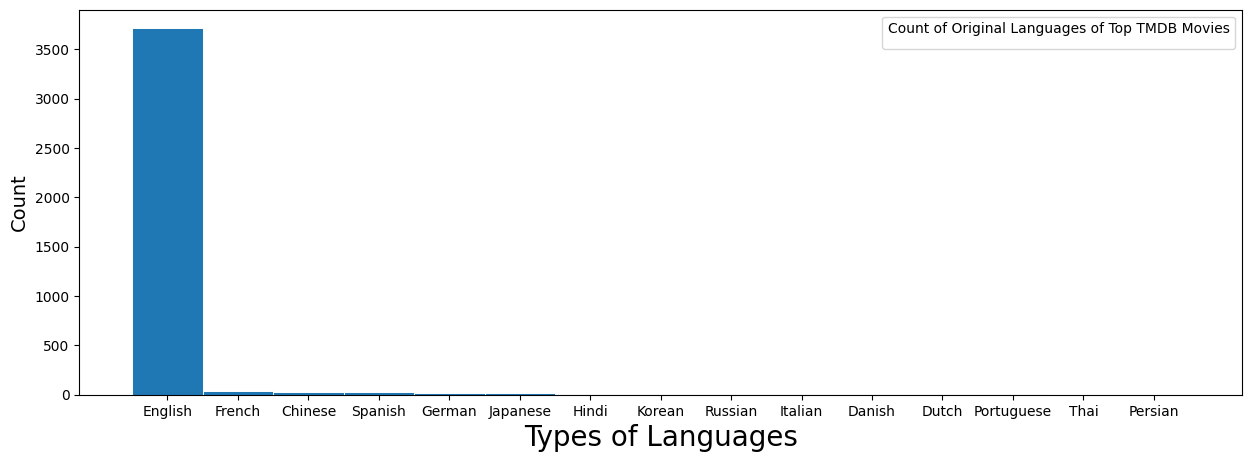

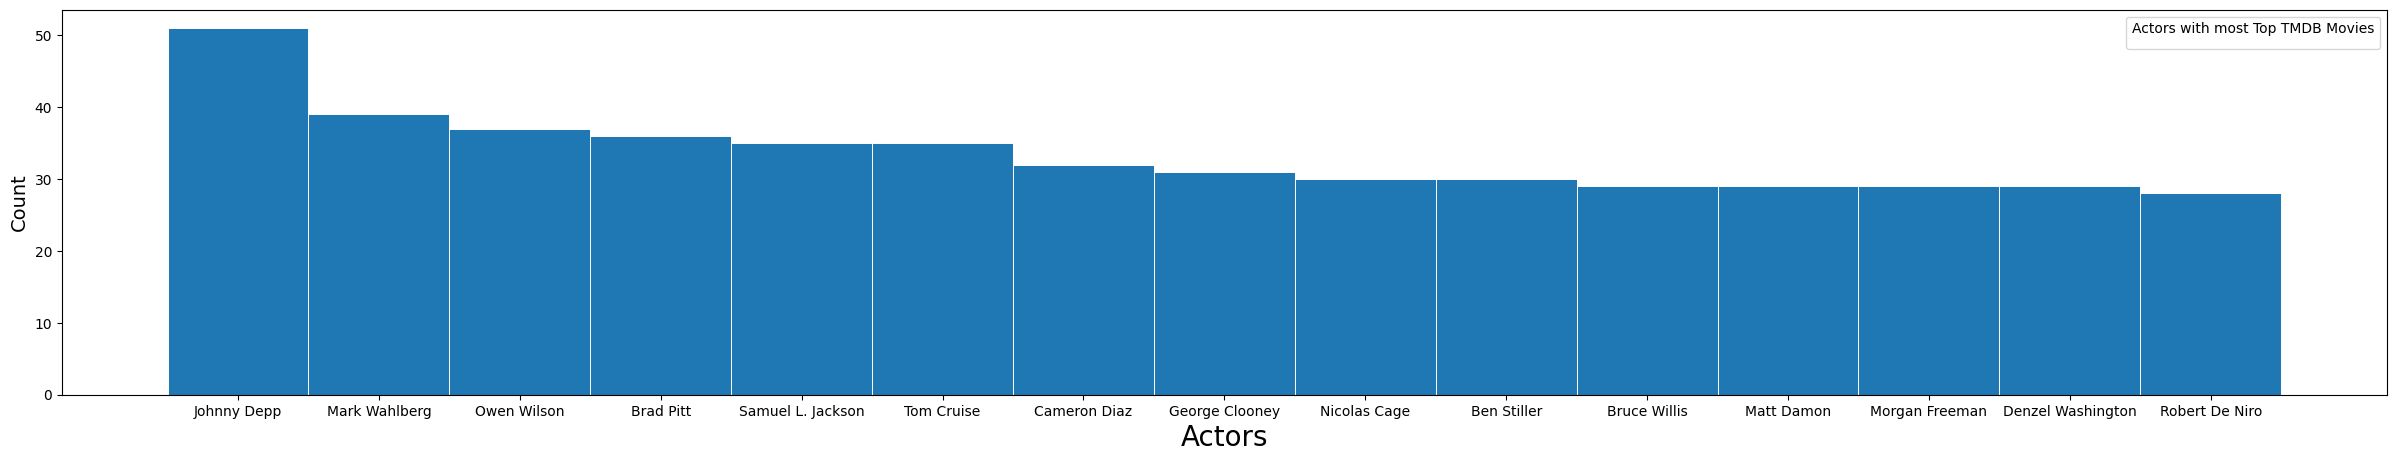

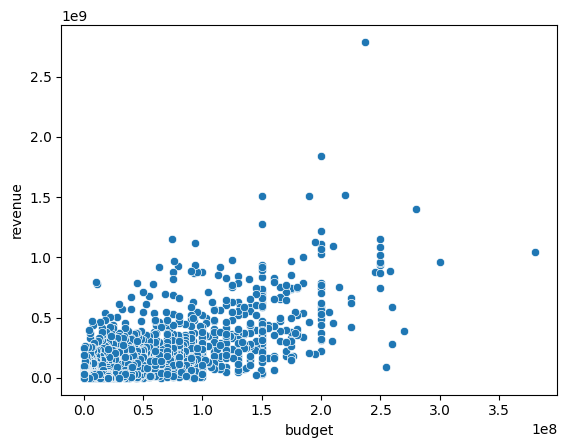

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


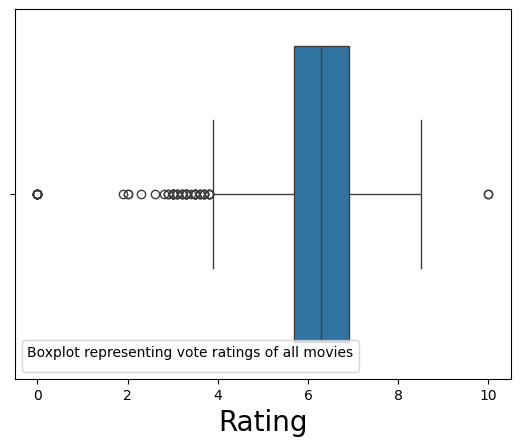

,Surrogate Key,budget,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count
0,1,237000000,"Action, Adventure, Fantasy, Science Fiction",19995,English,Avatar,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,"English, Spanish",Avatar,7.2,11800
1,2,300000000,"Adventure, Fantasy, Action",285,English,Pirates of the Caribbean: At World's End,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,English,Pirates of the Caribbean: At World's End,6.9,4500
2,3,245000000,"Action, Adventure, Crime",206647,English,Spectre,107.376788,"Columbia Pictures, Danjaq, B24","United Kingdom, United States of America",2015-10-26,880674609,148.0,"French, English, Spanish, Italian, German",Spectre,6.3,4466
3,4,250000000,"Action, Crime, Drama, Thriller",49026,English,The Dark Knight Rises,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",United States of America,2012-07-16,1084939099,165.0,English,The Dark Knight Rises,7.6,9106
4,5,260000000,"Action, Adventure, Science Fiction",49529,English,John Carter,43.926995,Walt Disney Pictures,United States of America,2012-03-07,284139100,132.0,English,John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4791,3909,13,Horror,157185,English,Tin Can Man,0.332679,"Park Films, Camera Stylo Films",Ireland,2007-01-01,36642838,84.0,English,Tin Can Man,2.0,1
4792,3910,20000,"Crime, Horror, Mystery, Thriller",36095,Japanese,キュア,0.212443,Daiei Studios,Japan,1997-11-06,99000,111.0,Japanese,Cure,7.4,63
4796,3911,7000,"Science Fiction, Drama, Thriller",14337,English,Primer,23.307949,Thinkfilm,United States of America,2004-10-08,424760,77.0,English,Primer,6.9,658
4798,3912,220000,"Action, Crime, Thriller",9367,Spanish,El Mariachi,14.269792,Columbia Pictures,"Mexico, United States of America",1992-09-04,2040920,81.0,Spanish,El Mariachi,6.6,238


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization of the count of languages in our dataset
movie_languages = df_movies["original_language"].value_counts(sort=True,ascending=False).head(15)

fig, ax = plt.subplots(figsize=(15,5))

plt.ylabel("Count",fontsize=14)
plt.xlabel("Types of Languages",fontsize=20)
plt.legend(title='Count of Original Languages of Top TMDB Movies')

plt.bar(movie_languages.index, movie_languages.values, width=1, edgecolor="white", linewidth=0.7)

# Visualization of the top Actors with most movies 
actors = df_movies_to_actors['actorID'].value_counts().head(15)
actor_names = df_unique_actors[df_unique_actors["actorID"].isin(actors.index)]["name"]

fig, ax = plt.subplots(figsize=(30,5))

plt.ylabel("Count",fontsize=14)
plt.xlabel("Actors",fontsize=20)
plt.legend(title='Actors with most Top TMDB Movies')


plt.bar(actor_names, actors.values, width=1, edgecolor="white", linewidth=0.7)

plt.show()

#scatter plot compring movies budget and revenue
sns.scatterplot(x='budget', y='revenue', data=df_movies) # need to work on this
plt.legend(title='ScatterPlot compring movies budget and revenue')
plt.show()

# boxplot taking the vote average
sns.boxplot(x='vote_average', data=df_movies) # need to work on this
plt.xlabel("Rating",fontsize=10)
plt.legend(title='Boxplot representing vote ratings of all movies')
plt.show()

df_movies